# Exective summary of Work Package 3

## Objectives

In this WP, you will work on a given training dataset. Your goal is to develop a fault detection model using the regression algorithms learnt in the class, in order to achieve best F1 score。

## Tasks

- Task 1: Develop a regression model to predict the reference value for motor temperature.
- Task 2: Develop a fault detection model using the regression model you developed in Task 1.

## Delierables

- A Jupyter notebook reporting the process and results of the above tasks


# Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch with your name, based on the "main" branch and switch to your own branch.
- Copy this notebook to the work space of your group, and rename it to TD_WP_3_Your name.ipynb
- After finishing this task, push your changes to the github repository of your group.

# Task 1: Predict normal behaviors through regression models

In this task, let us try to develop a best regression model to predict the normal behaviors of a given motor. In this exercise, we can use motor 6 as an example. You can easilily generate the approach to other models for the data challenge.

We can use all the dataset where motor 6 works normally as our dataset. Then, we can run a cross validation (based on sequence, not points) to test the performances of the developed model.

In this example, we mainly use the following performance metrics:
- max error: The max error between the predicted and the true values.
- Mean root squared error: The mean root squared error between the predicted and the true values.
- Out-of-boundary rate: The percentage that the residual error between the predicted and the true values is larger than a given threshold. Here, we set the thresold to be $3$ degree.

## Sub-task 1: Only use the features at the current moment.

[This notebook](demo_regression_mdl.ipynb) provides a basic demonstration of how to set up the experiment. Let us start by considering only using the features from the current moment. In the notebook, we show a baseline using a simple linear regression with all the features. Could you please try to improve the performance of the model?

A few possible directions:
- Feature selection?
- Smoothing?
- Removing sequence-to-sequence variablity? Adding features regarding time dynamics (see the TD for last lecture).
- Changing to other regression models? For this, you can try different regression models from [here](https://scikit-learn.org/stable/supervised_learning.html)

Put your code below.

Preprocess and importation

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import warnings
from scipy.signal import butter, filtfilt

from utility import read_all_csvs_one_test
from utility import read_all_test_data_from_path

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor

In [47]:
from utility import read_all_test_data_from_path
import numpy as np
import pandas as pd


n_int = 20

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    # Function to design a Butterworth low-pass filter
    def butter_lowpass(cutoff, fs, order=5):
        nyquist = 0.5 * fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a


    # Function to apply the Butterworth low-pass filter
    def lowpass_filter(data, cutoff_freq, sampling_freq, order=5):
        b, a = butter_lowpass(cutoff_freq, sampling_freq, order=order)
        filtered_data = filtfilt(b, a, data)
        return filtered_data


    # Set parameters for the low-pass filter
    cutoff_frequency = .05  # Adjust as needed
    sampling_frequency = 10  # Assuming your data is evenly spaced in time


    def customized_outlier_removal(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].ffill()
        df['position'] = lowpass_filter(df['position'], cutoff_frequency, sampling_frequency)
        df['position'] = df['position'].rolling(window=20, min_periods=1).mean()
        df['position'] = df['position'].round()

        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].rolling(window=20, min_periods=1).mean()

        # Make sure that the difference between the current and previous temperature cannot be too large.
        # Define your threshold
        threshold = 5
        # Shift the 'temperature' column by one row to get the previous temperature
        prev_tmp = df['temperature'].shift(1)
        # Calculate the absolute difference between current and previous temperature
        temp_diff = np.abs(df['temperature'] - prev_tmp)
        # Set the temperature to NaN where the difference is larger than the threshold
        df.loc[temp_diff > threshold, 'temperature'] = np.nan
        df['temperature'] = df['temperature'].ffill()

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 8000, np.nan)
        df['voltage'] = df['voltage'].ffill()
        df['voltage'] = lowpass_filter(df['voltage'], cutoff_frequency, sampling_frequency)
        df['voltage'] = df['voltage'].rolling(window=5, min_periods=1).mean()


    def cal_diff(df: pd.DataFrame, n_int: int):
        ''' # Description
        Calculate the difference between the current and previous n data point.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]

        # Calculate the difference between the current and previous n data point.
        df['temperature_diff'] = df['temperature'].diff(n_int)
        df['voltage_diff'] = df['voltage'].diff(n_int)
        df['position_diff'] = df['position'].diff(n_int)   

    # Start processing.
    customized_outlier_removal(df)
    cal_diff(df, n_int)

base_dictionary = '../../dataset/training_data/'
df_data = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=False)
df_data.describe()

from utility import read_all_csvs_one_test
import matplotlib.pyplot as plt
import pandas as pd
import os

# Get all the folders in the base_dictionary
path_list = os.listdir(base_dictionary)
# Only keep the folders, not the excel file.
path_list = path_list[:-1]

# Read the data.
df_data_smoothing = pd.DataFrame()
for tmp_path in path_list:
    path = base_dictionary + tmp_path
    # Read the data with the customized outlier removal function.
    tmp_df = read_all_csvs_one_test(path, tmp_path, pre_processing)
    df_data_smoothing = pd.concat([df_data_smoothing, tmp_df])
    df_data_smoothing = df_data_smoothing.reset_index(drop=True)

'''# Read the test conditions
df_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')

# Visulize the data
for selected_sequence_idx in path_list:
    filtered_df = df_data_smoothing[df_data_smoothing['test_condition'] == selected_sequence_idx]

    print('{}: {}\n'.format(selected_sequence_idx, df_test_conditions[df_test_conditions['Test id'] == selected_sequence_idx]['Description']))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    for ax, col in zip(axes.flat, ['data_motor_1_position', 'data_motor_2_position', 'data_motor_3_position', 
        'data_motor_1_temperature', 'data_motor_2_temperature', 'data_motor_3_temperature',
        'data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage']):
        ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
        ax.set_ylabel(col)

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
    for ax, col in zip(axes.flat, ['data_motor_4_position', 'data_motor_5_position', 'data_motor_6_position',
        'data_motor_4_temperature', 'data_motor_5_temperature', 'data_motor_6_temperature',
        'data_motor_4_voltage', 'data_motor_5_voltage', 'data_motor_6_voltage']):
        ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)
        ax.set_ylabel(col)

    plt.show()'''

"# Read the test conditions\ndf_test_conditions = pd.read_excel(base_dictionary+'Test conditions.xlsx')\n\n# Visulize the data\nfor selected_sequence_idx in path_list:\n    filtered_df = df_data_smoothing[df_data_smoothing['test_condition'] == selected_sequence_idx]\n\n    print('{}: {}\n'.format(selected_sequence_idx, df_test_conditions[df_test_conditions['Test id'] == selected_sequence_idx]['Description']))\n\n    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))\n    for ax, col in zip(axes.flat, ['data_motor_1_position', 'data_motor_2_position', 'data_motor_3_position', \n        'data_motor_1_temperature', 'data_motor_2_temperature', 'data_motor_3_temperature',\n        'data_motor_1_voltage', 'data_motor_2_voltage', 'data_motor_3_voltage']):\n        ax.plot(filtered_df['time'], filtered_df[col], marker='o', label=col)\n        ax.set_ylabel(col)\n\n    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))\n    for ax, col in zip(axes.flat, ['data_motor_4_positi

We select only the normal samples 

In [15]:
normal_test_id = ['20240105_164214', 
    '20240105_165300', 
    '20240105_165972', 
    '20240320_152031', 
    '20240320_153841', 
    '20240320_155664', 
    '20240321_122650', 
    '20240325_135213', 
    '20240426_141190', 
    '20240426_141532', 
    '20240426_141602', 
    '20240426_141726', 
    '20240426_141938', 
    '20240426_141980', 
    '20240503_164435']
df_data = df_data[df_data['test_condition'].isin(normal_test_id)]
df_data_smoothing = df_data_smoothing[df_data_smoothing['test_condition'].isin(normal_test_id)]

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
import warnings
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# Define the steps of the pipeline
# Ignore warnings.
warnings.filterwarnings('ignore')


# Steps for Decision Tree Regression
decision_tree_steps = [
    ('Normailzerr', MinMaxScaler()),  # Step 1: Normalization
    ('regressor', DecisionTreeRegressor())  # Step 2: Decision Tree Regressor
]

# Initialize Pipelines for each model
mdl_decision_tree = Pipeline(decision_tree_steps)

# List of models to be used in GridSearchCV
models = [
    ('Decision Tree Regression', mdl_decision_tree),
]


In [20]:
from utility import run_cv_one_motor

feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

threshold = 1
window_size = 1
sample_step = 1

def run_all_motors(df_data, mdl, feature_list, n_fold=5, threshold=3, window_size=1, sample_step=1,
            prediction_lead_time=1, single_run_result=True, mdl_type='reg'):
    all_results = []
    # Loop over all the six motors.
    for i in range(1, 7):
        print(f'Model for predicting temperature of motor {i}:')
        # Run cross validation.
        df_perf = run_cv_one_motor(motor_idx=i, df_data=df_data, mdl=mdl, feature_list=feature_list,
                n_fold=n_fold, threshold=threshold, window_size=window_size, sample_step=sample_step,
            prediction_lead_time=prediction_lead_time, single_run_result=single_run_result, mdl_type=mdl_type)
        all_results.append(df_perf)

    return all_results

def run_all_models(df_data, models, feature_list, n_fold=5, threshold=3, window_size=1, sample_step=1,
                   prediction_lead_time=1, single_run_result=True, mdl_type='reg'):
    summary_results = []
    for name, mdl in models:
        print(f'Running model: {name}')
        all_results = run_all_motors(df_data, mdl, feature_list, n_fold=n_fold, threshold=threshold, 
                                     window_size=window_size, sample_step=sample_step,
                                     prediction_lead_time=prediction_lead_time, single_run_result=single_run_result, 
                                     mdl_type=mdl_type)
        
        # Agregar resultados para cada motor
        df_all_results = pd.concat(all_results, keys=[f'Motor_{i}' for i in range(1, 7)])
        summary_results.append((name, df_all_results))
    
    return summary_results


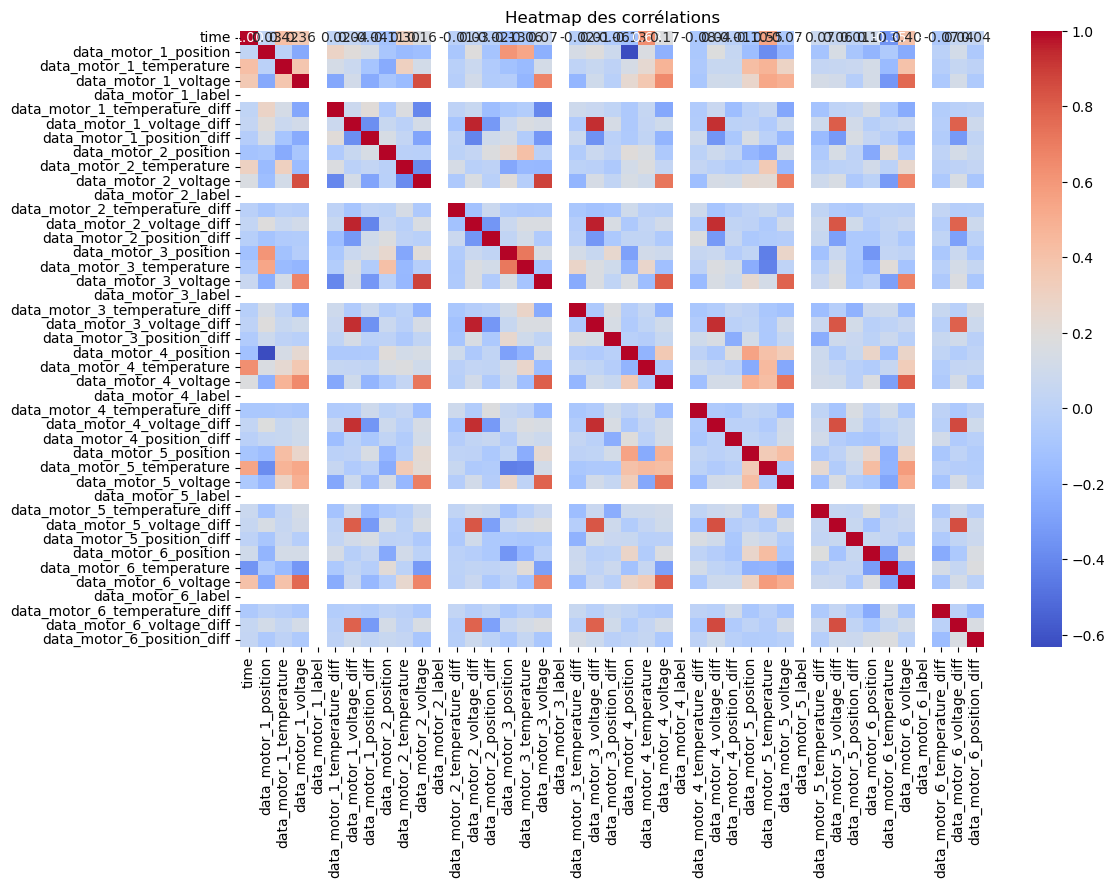

In [29]:

# Supprimer les colonnes non numériques si nécessaire
df_numeric = df_data_smoothing.select_dtypes(include=[np.number])

# Créer la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap des corrélations')
plt.show()

In [30]:
from utility import run_cv_one_motor

feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage',
                    'data_motor_2_position', 'data_motor_2_temperature', 'data_motor_2_voltage',
                    'data_motor_3_position', 'data_motor_3_temperature', 'data_motor_3_voltage',
                    'data_motor_4_position', 'data_motor_4_temperature', 'data_motor_4_voltage',
                    'data_motor_5_position', 'data_motor_5_temperature', 'data_motor_5_voltage',
                    'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage']

threshold = 1
window_size = 1
sample_step = 1

df_perf = run_cv_one_motor(single_run_result=False, motor_idx=6, df_data=df_data_smoothing, mdl=grid_search, 
            feature_list=feature_list_all, n_fold=5, 
            threshold=threshold, window_size=window_size, sample_step=sample_step, mdl_type='reg')

Model for motor 6:
Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits


In [31]:
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature','data_motor_1_voltage',
       'data_motor_1_temperature_diff', 'data_motor_1_voltage_diff','data_motor_1_position_diff', 
       'data_motor_2_position','data_motor_2_temperature', 'data_motor_2_voltage', 
       'data_motor_2_temperature_diff', 'data_motor_2_voltage_diff', 'data_motor_2_position_diff',
       'data_motor_3_position', 'data_motor_3_temperature','data_motor_3_voltage',
       'data_motor_3_temperature_diff', 'data_motor_3_voltage_diff','data_motor_3_position_diff', 
       'data_motor_4_position','data_motor_4_temperature', 'data_motor_4_voltage',
       'data_motor_4_temperature_diff', 'data_motor_4_voltage_diff', 'data_motor_4_position_diff',
       'data_motor_5_position', 'data_motor_5_temperature','data_motor_5_voltage',
       'data_motor_5_temperature_diff', 'data_motor_5_voltage_diff','data_motor_5_position_diff', 
       'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage',
       'data_motor_6_temperature_diff', 'data_motor_6_voltage_diff', 'data_motor_6_position_diff']


selected_features= ['time', 'data_motor_1_position', 'data_motor_1_temperature','data_motor_1_voltage',
       'data_motor_1_temperature_diff', 'data_motor_1_voltage_diff','data_motor_1_position_diff', 
       'data_motor_2_position','data_motor_2_temperature', 'data_motor_2_voltage', 
       'data_motor_2_temperature_diff',  'data_motor_2_position_diff',
       'data_motor_3_position', 'data_motor_3_temperature','data_motor_3_voltage',
       'data_motor_3_temperature_diff', 'data_motor_3_position_diff', 
       'data_motor_4_position','data_motor_4_temperature', 'data_motor_4_voltage',
       'data_motor_4_temperature_diff', 'data_motor_4_voltage_diff',
       'data_motor_5_position', 'data_motor_5_temperature','data_motor_5_voltage',
       'data_motor_5_temperature_diff', 'data_motor_5_voltage_diff','data_motor_5_position_diff', 
       'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage',
       'data_motor_6_temperature_diff', 'data_motor_6_voltage_diff', 'data_motor_6_position_diff']

threshold = 1
window_size = 1
sample_step = 1

all_model_results = run_all_models(df_data=df_data_smoothing, models=models, feature_list=selected_features, 
                                   threshold=threshold, window_size=window_size, sample_step=sample_step, 
                                   single_run_result=False)



Running model: SVR
Model for predicting temperature of motor 1:
Model for motor 1:
   Max error       RMSE  Exceed boundary rate
0  16.061425   6.874484              0.954466
1   6.746108   2.557510              0.559546
2  16.010235  10.262676              0.917906
3  11.372010   3.589694              0.549731
4   9.471613   6.321744              0.861193


Mean performance metric and standard error:
Max error: 11.9323 +- 4.0910
RMSE: 5.9212 +- 3.0277
Exceed boundary rate: 0.7686 +- 0.1981


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0   3.829156  1.968939              0.594503
1   3.159703  1.468753              0.410208
2   3.043657  1.208711              0.410008
3   1.405923  0.610767              0.170699
4   1.672862  0.789181              0.161843


Mean performance metric and standard error:
Max error: 2.6223 +- 1.0373
RMSE: 1.2093 +- 0.5429
Exceed boundary rate: 0.3495 +- 0.1834


Model for predicting temperatu

In [32]:
summary_data = {
    'Model': [],
    'Max error': [],
    'RMSE': [],
    'Exceed boundary rate': []
}

for model_name, df_results in all_model_results:
    max_error = df_results['Max error'].mean()
    mse = df_results['RMSE'].mean()
    exceed_boundary_rate = df_results['Exceed boundary rate'].mean()
    
    summary_data['Model'].append(model_name)
    summary_data['Max error'].append(f'{max_error:.2f}')
    summary_data['RMSE'].append(f'{mse:.2f}')
    summary_data['Exceed boundary rate'].append(f'{exceed_boundary_rate:.2f}')

summary_df = pd.DataFrame(summary_data)

print("Summary of the results - Only using features from the current moment\n")
print(summary_df)

best_model = summary_df.loc[summary_df['RMSE'].idxmin()]
print(f"\nThe best model is {best_model['Model']} with a Mean Squared Error (RMSE) of {best_model['RMSE']}.")
print(f"It uses the features: {', '.join(feature_list_all)} and includes standard scaling as preprocessing.")

Summary of the results - Only using features from the current moment

                      Model Max error  RMSE Exceed boundary rate
0                       SVR      6.85  3.27                 0.56
1     ElasticNet Regression      7.09  3.28                 0.57
2  Decision Tree Regression      8.77  3.99                 0.53

The best model is SVR with a Mean Squared Error (RMSE) of 3.27.
It uses the features: time, data_motor_1_position, data_motor_1_temperature, data_motor_1_voltage, data_motor_1_temperature_diff, data_motor_1_voltage_diff, data_motor_1_position_diff, data_motor_2_position, data_motor_2_temperature, data_motor_2_voltage, data_motor_2_temperature_diff, data_motor_2_voltage_diff, data_motor_2_position_diff, data_motor_3_position, data_motor_3_temperature, data_motor_3_voltage, data_motor_3_temperature_diff, data_motor_3_voltage_diff, data_motor_3_position_diff, data_motor_4_position, data_motor_4_temperature, data_motor_4_voltage, data_motor_4_temperature_diff, data

**Summary of the results - Only using features from the current moment**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Model 1 |   XX.X%  |   XX.X%   |  XX.X% | 
| Model 2 |   XX.X%  |   XX.X%   |  XX.X% | 
| Model 3 |   XX.X%  |   XX.X%   |  XX.X% | 

## Sub-task 2: Include the features in the past

Now, let's consider using the sliding window approach to include the past in the regression model as well. Please have a look at the demo notebook, run your experiment, and report the best models you could have if you apply the sliding window approach.

In [50]:
feature_list_all = ['time', 'data_motor_1_position', 'data_motor_1_temperature','data_motor_1_voltage',
       'data_motor_1_temperature_diff', 'data_motor_1_voltage_diff','data_motor_1_position_diff', 
       'data_motor_2_position','data_motor_2_temperature', 'data_motor_2_voltage', 
       'data_motor_2_temperature_diff', 'data_motor_2_voltage_diff', 'data_motor_2_position_diff',
       'data_motor_3_position', 'data_motor_3_temperature','data_motor_3_voltage',
       'data_motor_3_temperature_diff', 'data_motor_3_voltage_diff','data_motor_3_position_diff', 
       'data_motor_4_position','data_motor_4_temperature', 'data_motor_4_voltage',
       'data_motor_4_temperature_diff', 'data_motor_4_voltage_diff', 'data_motor_4_position_diff',
       'data_motor_5_position', 'data_motor_5_temperature','data_motor_5_voltage',
       'data_motor_5_temperature_diff', 'data_motor_5_voltage_diff','data_motor_5_position_diff', 
       'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage',
       'data_motor_6_temperature_diff', 'data_motor_6_voltage_diff', 'data_motor_6_position_diff']


selected_features= ['time', 'data_motor_1_position', 'data_motor_1_temperature','data_motor_1_voltage',
       'data_motor_1_temperature_diff', 'data_motor_1_voltage_diff','data_motor_1_position_diff', 
       'data_motor_2_position','data_motor_2_temperature', 'data_motor_2_voltage', 
       'data_motor_2_temperature_diff',  'data_motor_2_position_diff',
       'data_motor_3_position', 'data_motor_3_temperature','data_motor_3_voltage',
       'data_motor_3_temperature_diff', 'data_motor_3_position_diff', 
       'data_motor_4_position','data_motor_4_temperature', 'data_motor_4_voltage',
       'data_motor_4_temperature_diff', 'data_motor_4_voltage_diff',
       'data_motor_5_position', 'data_motor_5_temperature','data_motor_5_voltage',
       'data_motor_5_temperature_diff', 'data_motor_5_voltage_diff','data_motor_5_position_diff', 
       'data_motor_6_position', 'data_motor_6_temperature', 'data_motor_6_voltage',
       'data_motor_6_temperature_diff', 'data_motor_6_voltage_diff', 'data_motor_6_position_diff']

threshold = 3
window_size = 100
sample_step = 50

all_model_results = run_all_models(df_data=df_data_smoothing, models=models, feature_list=feature_list_all, 
                                   threshold=threshold, window_size=window_size, sample_step=sample_step, 
                                   single_run_result=False)



Running model: Decision Tree Regression
Model for predicting temperature of motor 1:
Model for motor 1:
   Max error      RMSE  Exceed boundary rate
0       16.3  2.930113              0.196392
1       19.5  6.975928              0.665438
2        9.2  1.198034              0.040998
3        5.9  1.056992              0.023810
4        6.0  2.131069              0.150232


Mean performance metric and standard error:
Max error: 11.3800 +- 6.2022
RMSE: 2.8584 +- 2.4233
Exceed boundary rate: 0.2154 +- 0.2619


Model for predicting temperature of motor 2:
Model for motor 2:
   Max error      RMSE  Exceed boundary rate
0        8.3  0.681309              0.022873
1        7.6  1.303777              0.077164
2        8.0  1.157204              0.094294
3        7.1  2.470719              0.119048
4        7.3  0.803459              0.000580


Mean performance metric and standard error:
Max error: 7.6600 +- 0.4930
RMSE: 1.2833 +- 0.7104
Exceed boundary rate: 0.0628 +- 0.0496


Model for predi

In [51]:
summary_data = {
    'Model': [],
    'Max error': [],
    'RMSE': [],
    'Exceed boundary rate': []
}

for model_name, df_results in all_model_results:
    max_error = df_results['Max error'].mean()
    mse = df_results['RMSE'].mean()
    exceed_boundary_rate = df_results['Exceed boundary rate'].mean()
    
    summary_data['Model'].append(model_name)
    summary_data['Max error'].append(f'{max_error:.2f}')
    summary_data['RMSE'].append(f'{mse:.2f}')
    summary_data['Exceed boundary rate'].append(f'{exceed_boundary_rate:.2f}')

summary_df = pd.DataFrame(summary_data)

print("Summary of the results - Only using features from the current moment\n")
print(summary_df)

best_model = summary_df.loc[summary_df['RMSE'].idxmin()]
print(f"\nThe best model is {best_model['Model']} with a Mean Squared Error (RMSE) of {best_model['RMSE']}.")
print(f"It uses the features: {', '.join(feature_list_all)} and includes standard scaling as preprocessing.")

Summary of the results - Only using features from the current moment

                      Model Max error  RMSE Exceed boundary rate
0  Decision Tree Regression      7.97  1.86                 0.15

The best model is Decision Tree Regression with a Mean Squared Error (RMSE) of 1.86.
It uses the features: time, data_motor_1_position, data_motor_1_temperature, data_motor_1_voltage, data_motor_1_temperature_diff, data_motor_1_voltage_diff, data_motor_1_position_diff, data_motor_2_position, data_motor_2_temperature, data_motor_2_voltage, data_motor_2_temperature_diff, data_motor_2_voltage_diff, data_motor_2_position_diff, data_motor_3_position, data_motor_3_temperature, data_motor_3_voltage, data_motor_3_temperature_diff, data_motor_3_voltage_diff, data_motor_3_position_diff, data_motor_4_position, data_motor_4_temperature, data_motor_4_voltage, data_motor_4_temperature_diff, data_motor_4_voltage_diff, data_motor_4_position_diff, data_motor_5_position, data_motor_5_temperature, data_moto

**Summary of the results - Sliding window**

Please add a table in the end, summarying the results from all the models. Please write a few texts to explain what is the best model you got (including the features and preprocessing you did), its performance, and how could you further improve it.

| Model   (also report parameters like window_size, sample_step, prediction_lead_time, etc.) | Max error | MRSE | Exceed boundary rate |
|---------|----------|-----------|--------|
| Model 1 |   XX.X%  |   XX.X%   |  XX.X% | 
| Model 2 |   XX.X%  |   XX.X%   |  XX.X% | 
| Model 3 |   XX.X%  |   XX.X%   |  XX.X% | 

# Task 2 Fault detection based on regression model

In this exercise, we use the dataset that contains the failure of motor 6 to test the fault detection model based on the regression model trained before. 

[This notebook](demo_FaultDetectReg.ipynb) presents a demonstration of how to use the provided supporting function to develop fault detection model based on the regression model. Please have a look at this notebook, and try to improve the performance of the baseline model.

In [ ]:
# Your code here:

## Summary of the results

Please add a table in the end, summarying the results from all the models (including the unsupervised learning models). Please write a few texts to explain what is the best model you got (including key parameters like threshold, window_size, sample_step, prediction_lead_time, etc), its performance, and how could you further improve it.

| Model   | Accuracy | Precision | Recall | F1   |
|---------|----------|-----------|--------|------|
| Model 1 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
| Model 2 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
| Model 3 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
